In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region

In [6]:
pjmw = pd.read_excel('PJMW_MW_Hourly.xlsx',
                   index_col=[0],
                  parse_dates=[0])
pjmw.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077
2002-12-31 02:00:00,4939
2002-12-31 03:00:00,4885
2002-12-31 04:00:00,4857
2002-12-31 05:00:00,4930


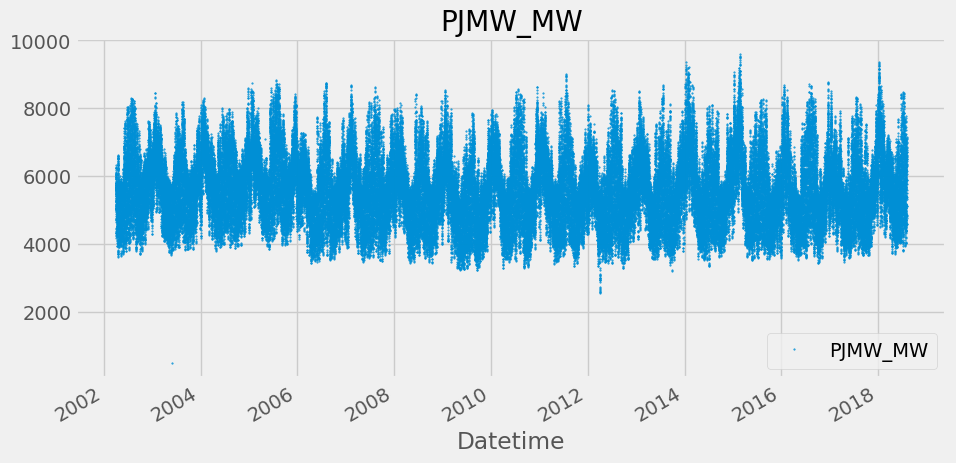

In [7]:
color_pal = sns.color_palette()
pjmw.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJMW_MW')
plt.show()


# Time Series Features

In [8]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjmw, label='PJMW_MW')
features_and_target = pd.concat([X, y], axis=1)

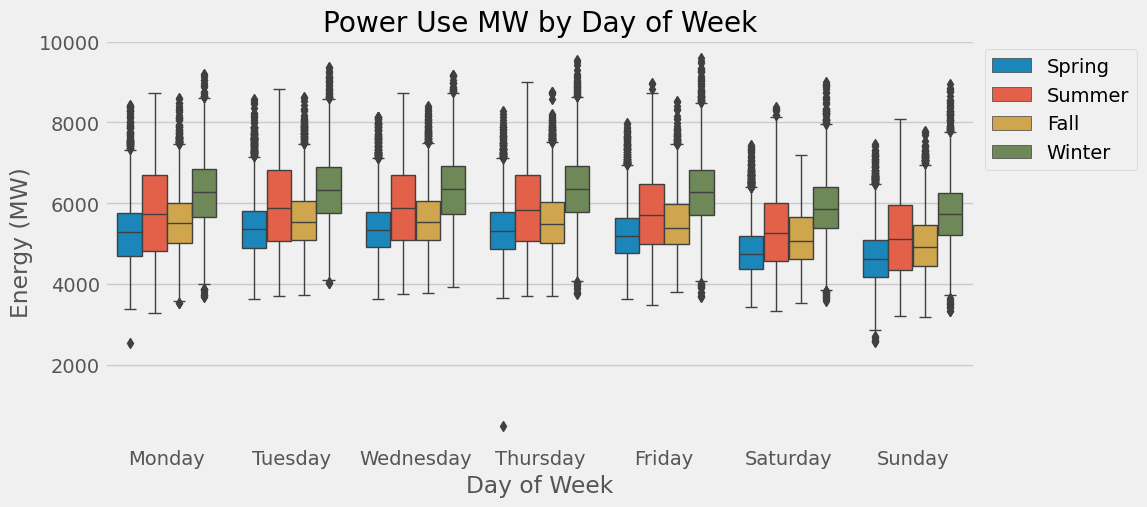

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJMW_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

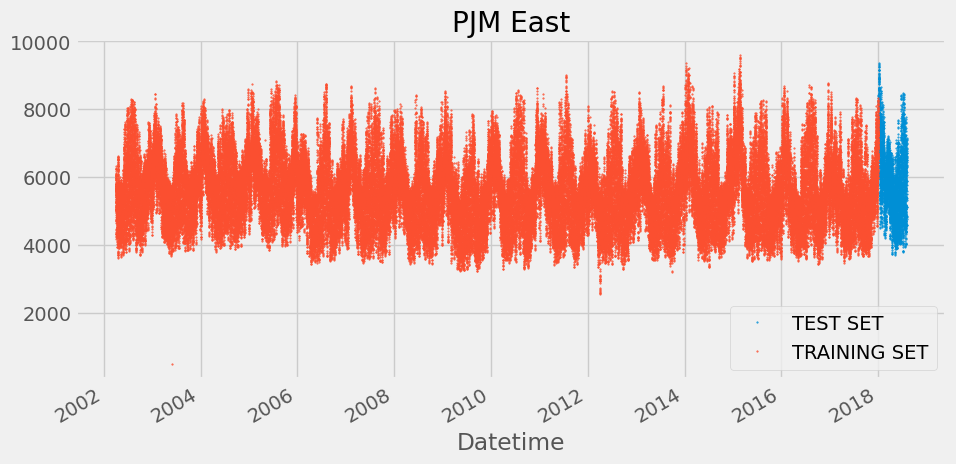

In [10]:
split_date = '1-Jan-2018'
pjmw_train = pjmw.loc[pjmw.index <= split_date].copy()
pjmw_test = pjmw.loc[pjmw.index > split_date].copy()

# Plot train and test so you can see where we have split
pjmw_test \
    .rename(columns={'PJMW_MW': 'TEST SET'}) \
    .join(pjmw_train.rename(columns={'PJMW_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.                                                                                                                       
Datetime column named: ds                                                                                                   
target : y

In [11]:
# Format data for prophet model using ds and y
pjmw_train_prophet = pjmw_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJMW_MW':'y'})

In [12]:
%%time
model = Prophet()
model.fit(pjmw_train_prophet)

01:00:44 - cmdstanpy - INFO - Chain [1] start processing
01:04:11 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 4min 2s


In [13]:
pjmw_test_prophet = pjmw_test.reset_index() \.rename(columns={'Datetime':'ds','PJMW_MW':'y'})
pjmw_test_fcst = model.predict(pjmw_test_prophet)

In [14]:
pjmw_test_fcst = model.predict(pjmw_test_prophet)

In [15]:
pjmw_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 01:00:00,5483.973653,4287.385555,5799.675017,5483.973653,5483.973653,-440.396048,-440.396048,-440.396048,-631.463757,...,-169.681962,-169.681962,-169.681962,360.749671,360.749671,360.749671,0.0,0.0,0.0,5043.577605
1,2018-01-01 02:00:00,5483.968153,4147.471111,5623.823317,5483.968153,5483.968153,-621.866049,-621.866049,-621.866049,-840.170647,...,-143.031459,-143.031459,-143.031459,361.336057,361.336057,361.336057,0.0,0.0,0.0,4862.102103
2,2018-01-01 03:00:00,5483.962653,4087.593891,5516.463991,5483.962653,5483.962653,-703.489793,-703.489793,-703.489793,-948.842231,...,-116.579194,-116.579194,-116.579194,361.931632,361.931632,361.931632,0.0,0.0,0.0,4780.472860
3,2018-01-01 04:00:00,5483.957153,4106.607827,5505.017315,5483.957153,5483.957153,-675.273812,-675.273812,-675.273812,-947.343625,...,-90.466573,-90.466573,-90.466573,362.536386,362.536386,362.536386,0.0,0.0,0.0,4808.683340
4,2018-01-01 05:00:00,5483.951653,4197.104344,5678.481203,5483.951653,5483.951653,-530.779134,-530.779134,-530.779134,-829.100247,...,-64.829198,-64.829198,-64.829198,363.150312,363.150312,363.150312,0.0,0.0,0.0,4953.172519


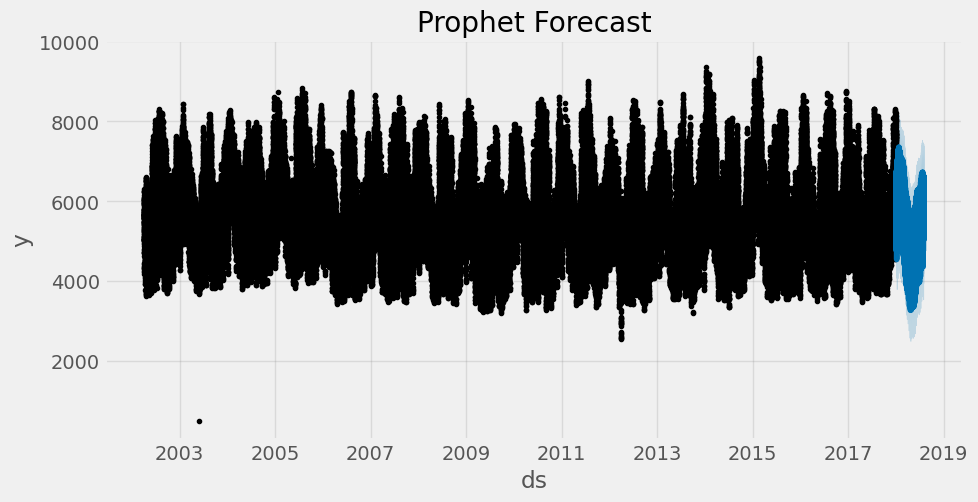

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjmw_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

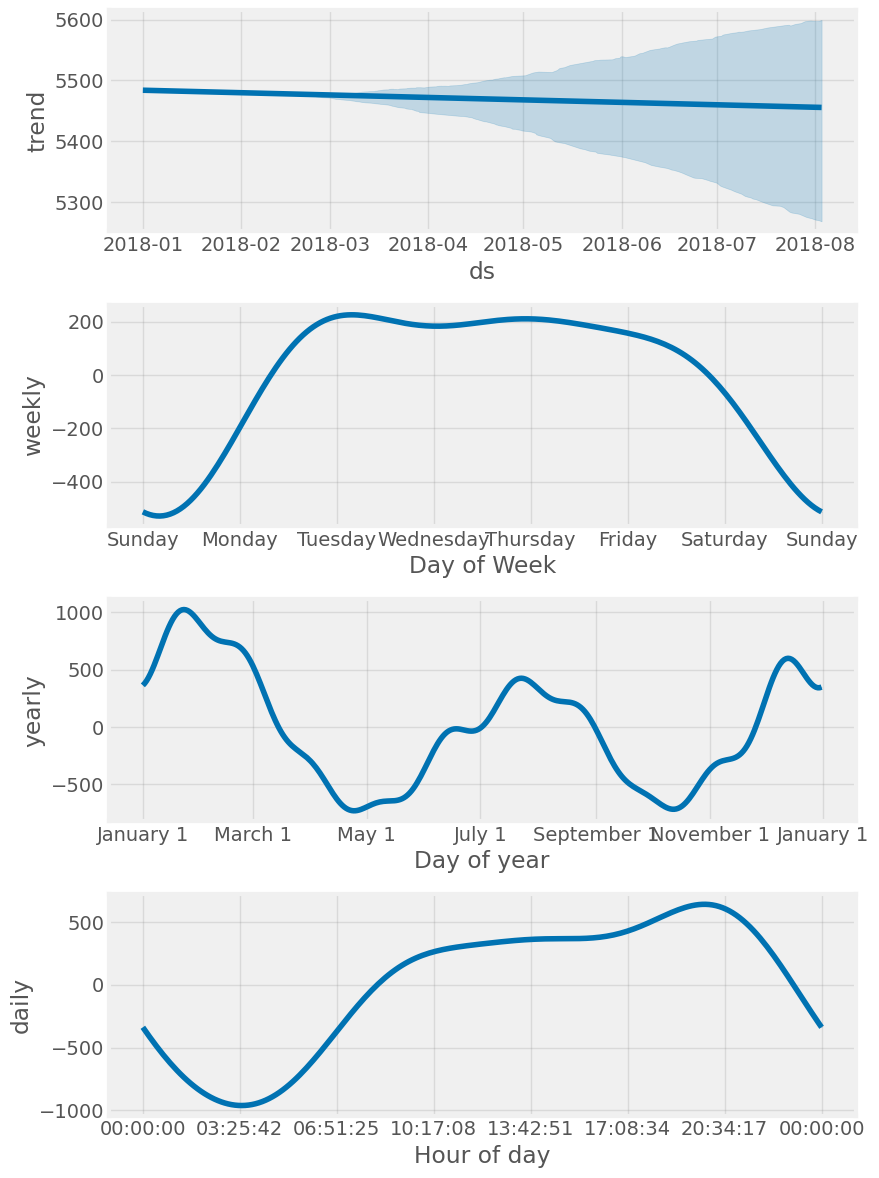

In [17]:
fig = model.plot_components(pjmw_test_fcst)
plt.show()

# Compare Forecast to Actuals

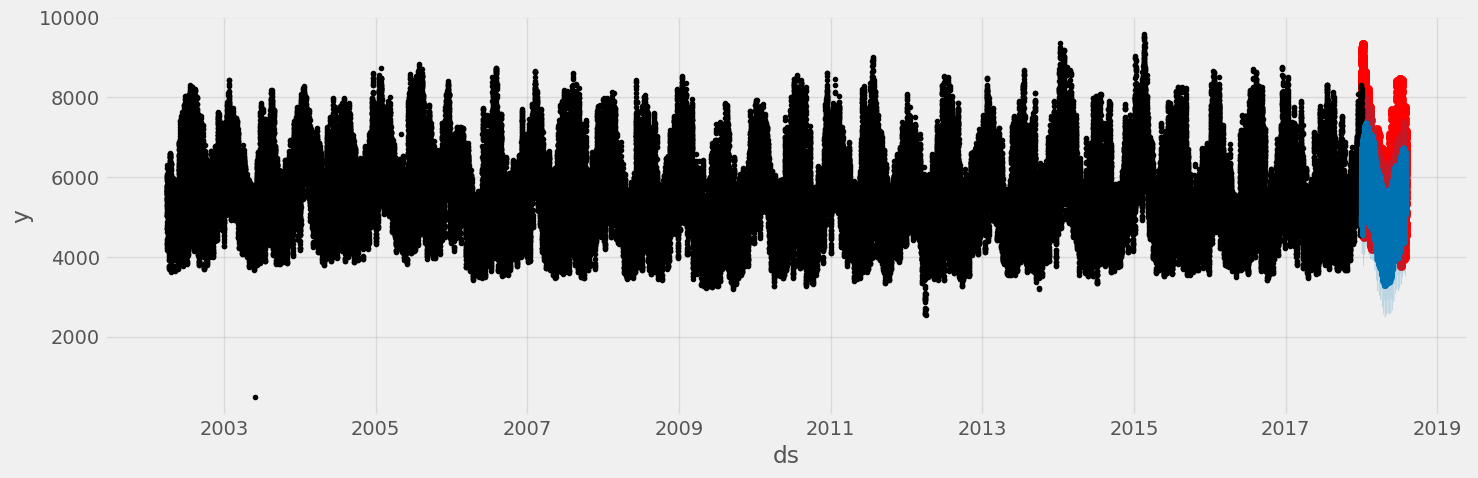

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst, ax=ax)

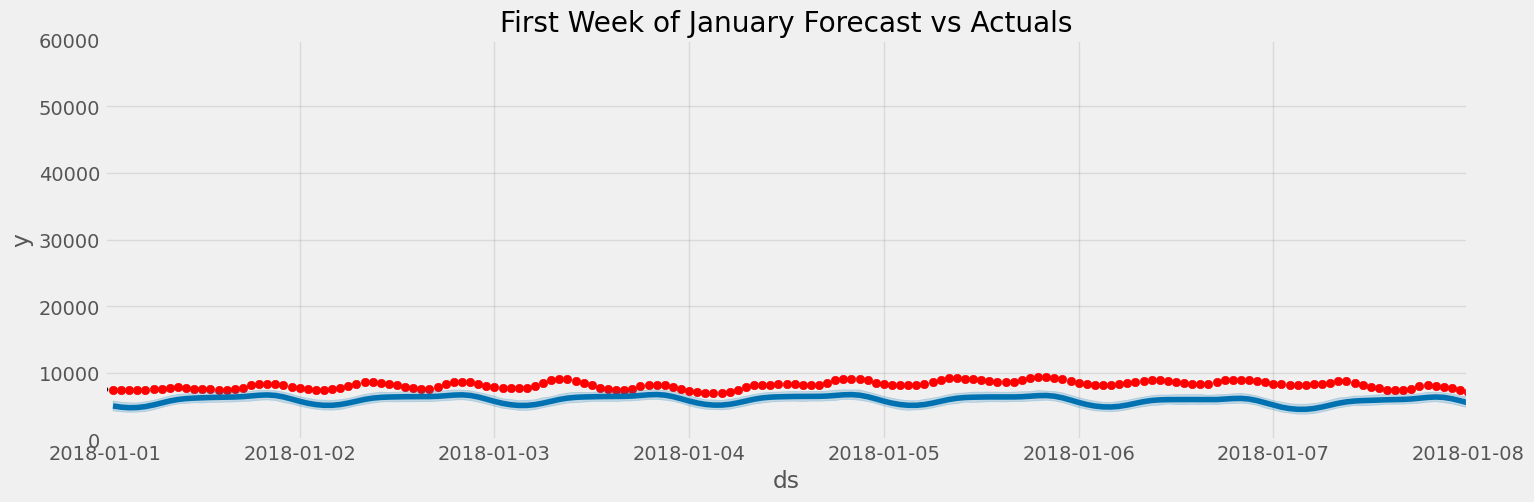

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2018', upper='01-08-2018')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics


In [20]:
model = Prophet()
model.fit(pjmw_train_prophet)
pjmw_test_prophet = pjmw_test.reset_index() \
                .rename(columns={'Datetime':'ds','PJMW_MW':'y'})
pjmw_test_fcst = model.predict(pjmw_test_prophet)
np.sqrt(mean_squared_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat']))

1018.4861290688868

In [21]:
mean_absolute_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat'])

794.9493851666233

In [22]:
mean_absolute_percentage_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat'])

13.372431471863845

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays


In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjmw.index.min(),
                        end=pjmw.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


In [24]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjmw_train_prophet)

01:09:11 - cmdstanpy - INFO - Chain [1] start processing
01:13:46 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 5min 7s


In [25]:
# Predict on training set with model
pjmw_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjmw_test_prophet)

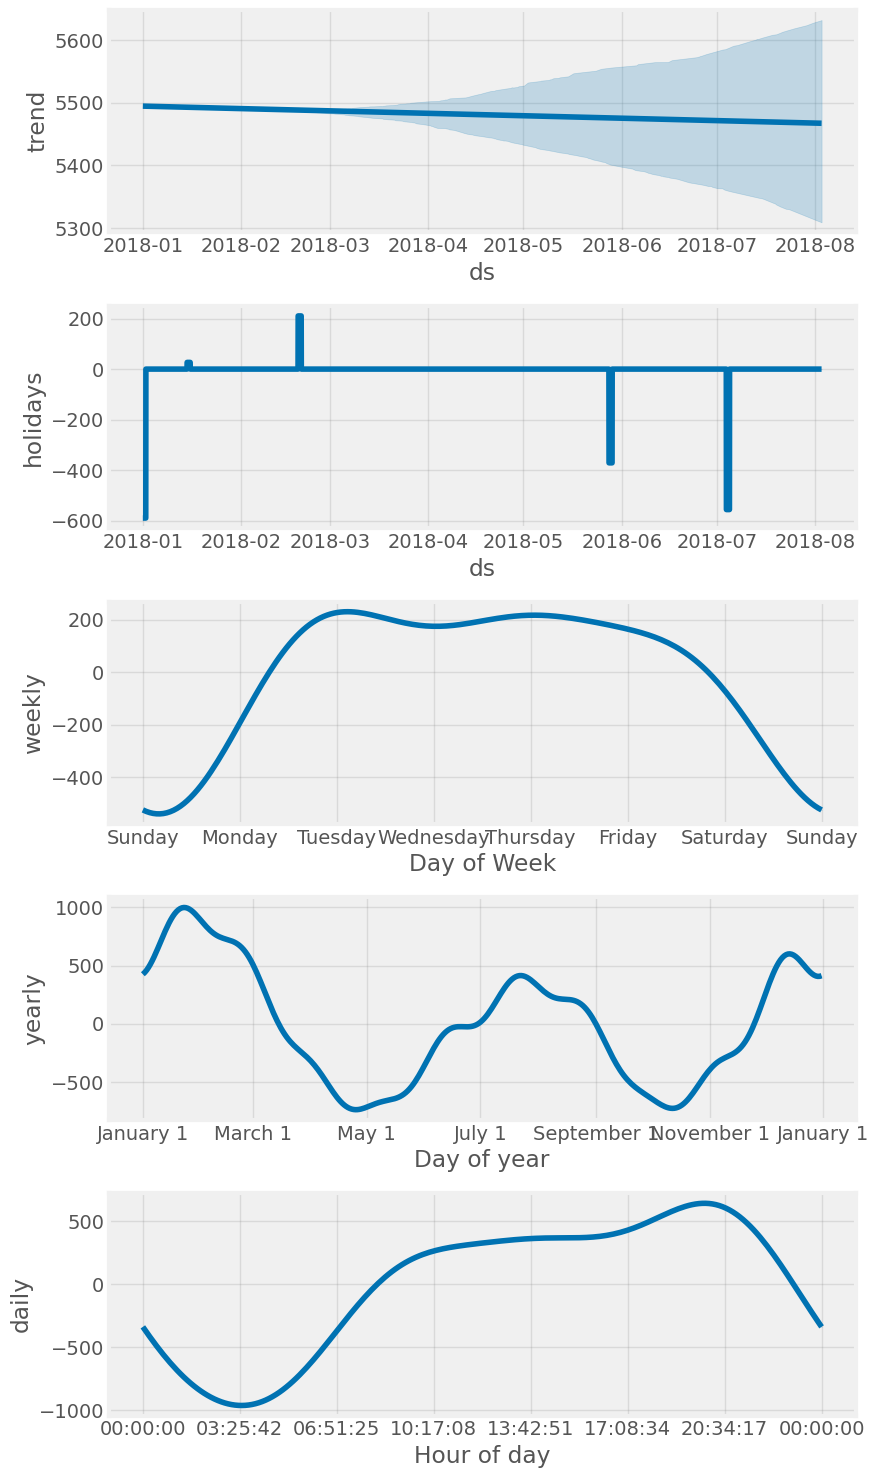

In [26]:
fig = model_with_holidays.plot_components(
    pjmw_test_fcst_with_hols)
plt.show()

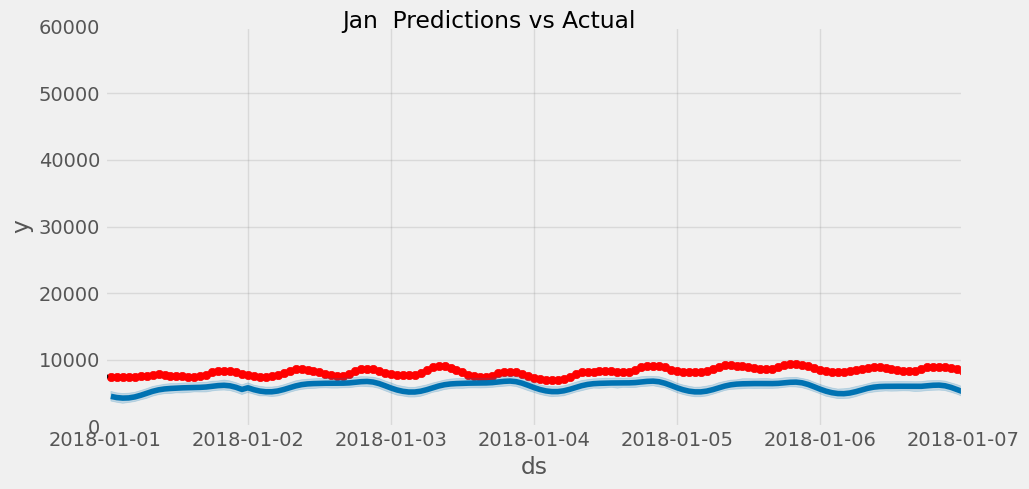

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='01-01-2018',
              upper='01-07-2018')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Jan  Predictions vs Actual')

In [28]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjmw_train_prophet)
pjmw_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjmw_test_prophet)
np.sqrt(mean_squared_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst_with_hols['yhat']))

1021.234018055264

In [29]:
mean_absolute_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst_with_hols['yhat'])

797.8470916777826

# Predict into the Future
We can use the built in make_future_dataframe method to build our future dataframe and make predictions.



In [30]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [31]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2018-01-01 01:00:00,4532.749420
1,2018-01-01 02:00:00,4352.032214
2,2018-01-01 03:00:00,4271.132455
3,2018-01-01 04:00:00,4300.046883
4,2018-01-01 05:00:00,4445.199945


In [32]:
forecast[['ds','yhat']].tail()

,ds,yhat
8755,2018-12-31 20:00:00,6717.922774
8756,2018-12-31 21:00:00,6637.000676
8757,2018-12-31 22:00:00,6414.937430
8758,2018-12-31 23:00:00,6096.782078
8759,2019-01-01 00:00:00,5758.734447
